In [1]:
from sklearn.datasets import load_iris
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
iris = load_iris()
data_x = iris.data
data_lable = iris.target

In [3]:
#距离矩阵
def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

In [4]:
#邻接矩阵
def myKNN(S, k, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] 

        for j in neighbours_id:
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j]

    return A

In [5]:
def getEigVec(L,cluster_num):  #从拉普拉斯矩阵获得特征矩阵
    eigval,eigvec = np.linalg.eig(L)
    dim = len(eigval)
    dictEigval = dict(zip(eigval,range(0,dim)))
    kEig = np.sort(eigval)[0:cluster_num]
    ix = [dictEigval[k] for k in kEig]
    return eigval[ix],eigvec[:,ix]

In [6]:
#标准化的拉普拉斯矩阵
def calLaplacianMatrix(adjacentMatrix):

    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)

    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix

    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)

In [7]:
def q_neighbors(A,q=16):
    n = []
    for i in range(len(A)):
        inds = np.argsort(A[i])
        inds = inds[-q:-1]
        n.append(inds)
    return np.array(n)

In [8]:
Similarity = calEuclidDistanceMatrix(data_x)
A  = myKNN(Similarity,k=16)
qnn = q_neighbors(A)

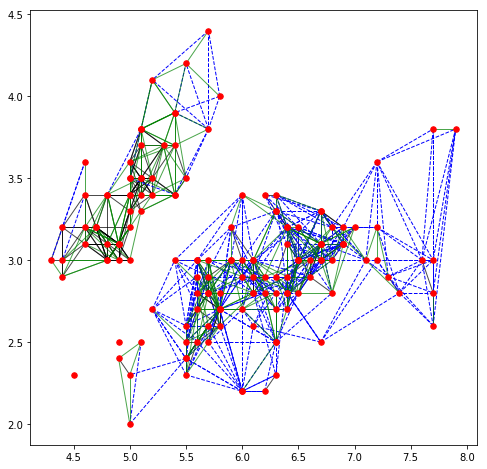

In [9]:
data = np.array(data_x)
data = data.T
pos = np.c_[data[0],data[1]]
plt.figure(figsize=(8,8))
G = nx.Graph() 
# 向图G添加节点和边
G.add_nodes_from([i for i in range(150)])
for i in range(len(A)):
    for j in range(len(A)):
        # 只有i是j的近邻且j是i的近邻，二者之间才有边
        if(i in qnn[j] and j in qnn[i]):
            G.add_edge(i,j,weight=A[i,j])
# 画出节点 
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=30, node_shape='o')
# 将图G中的边按照权重分组
edges_list1=[]
edges_list2=[]
edges_list3=[]
for (u,v,d) in G.edges(data='weight'):
    if d > 0.95:
        edges_list1.append((u,v))
    elif d < 0.9:
        edges_list2.append((u,v))
    else:
        edges_list3.append((u,v))
# 按照分好的组，以不同样式画出边
nx.draw_networkx_edges(G, pos, edgelist=edges_list1, width=1, alpha=0.7, edge_color='k', style='solid')
nx.draw_networkx_edges(G, pos, edgelist=edges_list2, width=1, alpha=1.0, edge_color='b', style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=edges_list3, width=1, alpha=0.7, edge_color='g', style='solid')
plt.savefig("iris_graph.png")
plt.show()

In [10]:
Similarity = calEuclidDistanceMatrix(data_x)
A  = myKNN(Similarity,k=16)
L = calLaplacianMatrix(A)
eigval,eigvec = getEigVec(L,3)

In [11]:
def findCentroids(data_get, k):    # 随机获取k个质心
    return random.sample(data_get, k)

def calculateDistance(vecA, vecB):    # 计算向量vecA和向量vecB之间的欧氏距离
    return np.sqrt(np.sum(np.square(vecA - vecB)))


def minDistance(data_get, centroidList):
    # 计算data_get中的元素与centroidList中k个聚类中心的欧式距离，找出距离最小的
    # 将该元素加入相应的聚类中
    cluster_result = list()
    clusterDict = dict()  # 用字典存储聚类结果
    for element in data_get:
        vecA = np.array(element)  # 转换成数组形式
        flag = 0  # 元素分类标记，记录与相应聚类距离最近的那个类
        minDis = float("inf")  # 初始化为最大值

        for i in range(len(centroidList)):
            vecB = np.array(centroidList[i])
            distance = calculateDistance(vecA, vecB)  # 两向量间的欧式距离
            if distance < minDis:
                minDis = distance
                flag = i  # 保存与当前item距离最近的那个聚类的标记

        if flag not in clusterDict.keys():  # 簇标记不存在，进行初始化
            clusterDict[flag] = list()
        clusterDict[flag].append(element)  # 加入相应的类中
        cluster_result.append(flag)
    return clusterDict,cluster_result  # 返回新的聚类结果

def getCentroids(clusterDict):

    centroidList = list()
    for key in clusterDict.keys():
        centroid = np.mean(np.array(clusterDict[key]), axis=0)  # 求聚类中心即求解每列的均值
        centroidList.append(centroid)
 
    return np.array(centroidList).tolist()
 

def calculate_Var(clusterDict, centroidList):
    # 计算聚类间的均方误差
    # 将类中各个向量与聚类中心的距离进行累加求和

    sum = 0.0
    for key in clusterDict.keys():
        vecA = np.array(centroidList[key])
        distance = 0.0
        for item in clusterDict[key]:
            vecB = np.array(item)
            distance += calculateDistance(vecA, vecB)
        sum += distance

    return sum

In [12]:
data = list(eigvec)
    
centroidList = findCentroids(data, 3)  # 随机获取3个聚类中心
clusterDict,cluster_result = minDistance(data, centroidList)  # 第一次聚类迭代
newVar = calculate_Var(clusterDict, centroidList)  # 计算均方误差值，通过新旧均方误差来获得迭代终止条件
oldVar = -0.0001  # 初始化均方误差

while abs(newVar - oldVar) >= 0.0001:  # 当连续两次聚类结果差距小于0.0001时，迭代结束
    centroidList = getCentroids(clusterDict)  # 获得新的聚类中心
    clusterDict, cluster_result = minDistance(data, centroidList)  # 新的聚类结果
    oldVar = newVar
    newVar = calculate_Var(clusterDict, centroidList)


In [13]:
num = 0
for i in range(len(cluster_result)):
    if(cluster_result[i] == data_lable[i]):
        num += 1
num/150

0.9066666666666666